# Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import time

# 1. Importing Data and Preprocessing

In [39]:
df = pd.read_pickle("C:/Users/zulla/OneDrive/Stevens/FE 800 Final Project/fe800_data.pkl 2/fe800_data.pkl")

In [40]:
#Making all columns numerical
columns = ['Price', 'Volume', 'Trades', 'Return', 'Age', 'TTM', 'Stock_Return',
       'Stock_Volume', 'ETF_Return', 'PV', 'YTM', 'Duration', 'DV01',
       'Convexity', 'RunningCoupon', 'ParSpread', 'CDSRealRecovery',
       'UpfrontBASpreadAverage', 'ConvBASpreadAverage', 'EstimatedNotional',
       'WklyNetNotional', 'DP', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC']

for col in columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [41]:
df = df.dropna()

In [42]:
df.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-03  86.821 -0.785507     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.573559    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.637707    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.115591     7.0  0.008142  5.060274  24.452055   
          2018-07-10  87.241 -0.519514    11.0 -0.024117  5.063014  24.449315   

                      Stock_Return  Stock_Volume  ETF_Return        PV  ...  \
cusip     trd_dt                                                        ...   
00206RBH4 2018-07-03      0.015523     -0.171355   -0.005025  0.004849  ...   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749  ...   
          2018-07-06      0.002454      0.232636    0.007858  0.001668  ...   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931  ...   
          2018-07-10      0.010886      0.103056    0.002150 -0.001502  ...   

                      ConvBASpreadAverage  EstimatedNotional  WklyNetNotional  \
cusip     trd_dt                                                                
00206RBH4 2018-07-03             0.001092          5000000.0     1.173281e+09   
          2018-07-05             0.001299          5000000.0     1.152963e+09   
          2018-07-06             0.001073          5000000.0     1.152963e+09   
          2018-07-09             0.001243          5000000.0     1.152963e+09   
          2018-07-10             0.001245          5000000.0     1.152963e+09   

                            DP   AA    A  BBB   BB    B  CCC  
cusip     trd_dt                                              
00206RBH4 2018-07-03  0.142425  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-05  0.142928  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-06  0.143275  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-09  0.141889  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-10  0.140366  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 28 columns]

In [7]:
#To see how the data is formatted
pred_df = predict_prices(df)
pred_df

CUSIP Trade_Date  Actual_Price  Predicted_Price
0       00206RBH4 2018-11-30     83.034500        83.132294
1       00206RBH4 2018-12-03     84.269000        83.849167
2       00206RBH4 2018-12-04     84.351400        83.877075
3       00206RBH4 2018-12-06     85.026769        84.659592
4       00206RBH4 2018-12-07     85.307869        84.632233
...           ...        ...           ...              ...
612115  98978VAL7 2023-06-26     93.630000        93.430222
612116  98978VAL7 2023-06-27     93.296000        93.032700
612117  98978VAL7 2023-06-28     93.682000        93.377243
612118  98978VAL7 2023-06-29     93.169000        92.023224
612119  98978VAL7 2023-06-30     93.376000        92.933899

[612120 rows x 4 columns]

In [8]:
#Get list of all CUSIPs
unique_cusips = pred_df['CUSIP'].unique()

list_of_cusips = unique_cusips.tolist()

print(list_of_cusips)
print('There are: ', len(list_of_cusips), 'bonds being traded')

['00206RBH4', '00206RBK7', '00206RCP5', '00206RCQ3', '00206RCU4', '00206RDJ8', '00206RDK5', '00206RDQ2', '00206RDR0', '002824BF6', '002824BG4', '002824BH2', '00287YAM1', '00287YAR0', '00287YAS8', '00287YAV1', '00287YAW9', '00440EAW7', '00817YAF5', '00817YAZ1', '013716AU9', '02209SAM5', '02209SAR4', '02209SAV5', '023135AP1', '023135AQ9', '023135BC9', '023135BF2', '023135BJ4', '023135BM7', '025816BF5', '026874DF1', '026874DL8', '03040WAD7', '03040WAR6', '03073EAP0', '031162BZ2', '031162CD0', '031162CF5', '031162CQ1', '032654AN5', '03523TBF4', '03523TBT4', '035240AG5', '035240AL4', '035240AM2', '035240AN0', '035240AP5', '035242AN6', '03524BAF3', '037833AL4', '037833AT7', '037833BA7', '037833BH2', '037833BW9', '037833BX7', '037833CD0', '037833CH1', '037833CJ7', '037833CR9', '037833CX6', '037833DB3', '037833DD9', '037833DG2', '037833DK3', '038222AL9', '038222AM7', '046353AD0', '046353AG3', '046353AM0', '046353AN8', '049560AM7', '05565QDH8', '05565QDN5', '057224AZ0', '05723KAE0', '05723KAF7'

# 2. Functions

## Predicting Prices Model 

In [43]:
def predict_prices(df, n_splits=12):
    predictions = []

    for cusip, cusip_df in df.groupby(level='cusip'):
        cusip_df = cusip_df.sort_index(level='trd_dt')
        X = cusip_df.drop(['Price'], axis=1)
        y = cusip_df['Price']

        tscv = TimeSeriesSplit(n_splits=n_splits)

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = xgb.XGBRegressor(objective='reg:squarederror')
            model.fit(X_train, y_train)

            predicted_prices = model.predict(X_test)
            test_dates = cusip_df.iloc[test_index].index.get_level_values('trd_dt')

            for date, predicted_price in zip(test_dates, predicted_prices):
                # Accessing y_test with multi-index (CUSIP, date)
                actual_price = y_test.loc[(cusip, date)] if (cusip, date) in y_test.index else np.nan

                if not np.isnan(actual_price):
                    predictions.append((cusip, date, actual_price, predicted_price))



    prediction_df = pd.DataFrame(predictions, columns=['CUSIP', 'Trade_Date', 'Actual_Price', 'Predicted_Price'])
    return prediction_df

## Transaction Cost Function - Interactive Brokers

In [44]:
def calculate_transaction_cost(order_value):
    cost = order_value * 0.0010  # 10 bps
    cost = max(1, cost)  # Minimum of $1
    cost = min(250, cost)  # Maximum of $250
    return cost

## Backtesting Strategy Function

In [45]:
#Can change the threshold, currently at a 1% differnce in price
def backtest_strategy(predicted_prices_df, starting_portfolio=100000, trade_threshold=0.01):
    portfolio_value = starting_portfolio
    portfolio_values = [portfolio_value]
    trade_dates = []
    trade_actions = {}
    cusip_profit = {}
    trade_details = []
    wins = 0
    losses = 0
    max_drawdown = 0
    peak_portfolio_value = starting_portfolio

    for index, row in predicted_prices_df.iterrows():
        cusip, trade_date, actual_price, predicted_price = row['CUSIP'], row['Trade_Date'], row['Actual_Price'], row['Predicted_Price']
        trade_dates.append(trade_date)
        previous_portfolio_value = portfolio_value

        # Implement your trading logic here
        percentage_diff = (predicted_price - actual_price) / actual_price
        if abs(percentage_diff) >= trade_threshold:
            
            #I want to fix trade size, maybe just equally divide by # of bonds so 610?
            trade_size = portfolio_value * trade_threshold
            transaction_cost = calculate_transaction_cost(trade_size)
            action = ''

            if percentage_diff > 0:
                action = 'Buy'
                portfolio_value -= trade_size + transaction_cost
            elif percentage_diff < 0:
                action = 'Sell'
                portfolio_value += trade_size - transaction_cost

            # Record wins, losses, and actions
            if portfolio_value > previous_portfolio_value:
                wins += 1
            elif portfolio_value < previous_portfolio_value:
                losses += 1

            if cusip not in trade_actions:
                trade_actions[cusip] = []
            trade_actions[cusip].append((trade_date, action, actual_price))

            # Record trade details
            profit_loss = portfolio_value - previous_portfolio_value
            trade_details.append({'CUSIP': cusip, 'Date': trade_date, 'Profit': profit_loss})

        portfolio_values.append(portfolio_value)

        # Update peak portfolio value for drawdown calculation
        peak_portfolio_value = max(peak_portfolio_value, portfolio_value)
        drawdown = (peak_portfolio_value - portfolio_value) / peak_portfolio_value
        max_drawdown = max(max_drawdown, drawdown)

        # Accumulate profit/loss per CUSIP
        if cusip not in cusip_profit:
            cusip_profit[cusip] = 0
        cusip_profit[cusip] += portfolio_value - previous_portfolio_value

    # Calculate win percentage
    total_trades = wins + losses
    win_percentage = (wins / total_trades) * 100 if total_trades > 0 else 0

    # Sort CUSIPs and trades for analysis
    most_profitable_cusips = sorted(cusip_profit.items(), key=lambda x: x[1], reverse=True)
    best_trades = sorted(trade_details, key=lambda x: x['Profit'], reverse=True)

    # Ensure trade_dates and portfolio_values are synchronized
    if len(trade_dates) + 1 == len(portfolio_values):
        trade_dates.insert(0, predicted_prices_df.iloc[0]['Trade_Date'])

    return trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades


#trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.01)

## Plotting CUSIP Level Trade Signals

In [46]:
def plot_cusip_trades(predicted_prices_df, trade_actions, cusip_to_plot, start_date=None, end_date=None):
    # Convert start_date and end_date to Timestamp if they are not None
    if start_date:
        start_date = pd.to_datetime(start_date)
    if end_date:
        end_date = pd.to_datetime(end_date)

    # Filter the DataFrame for the specific CUSIP
    cusip_data = predicted_prices_df[predicted_prices_df['CUSIP'] == cusip_to_plot]

    # If start_date and/or end_date are specified, filter the data accordingly
    if start_date:
        cusip_data = cusip_data[cusip_data['Trade_Date'] >= start_date]
    if end_date:
        cusip_data = cusip_data[cusip_data['Trade_Date'] <= end_date]

    # Extract dates and prices
    dates = cusip_data['Trade_Date']
    prices = cusip_data['Actual_Price']

    # Prepare buy and sell points within the specified time frame
    buy_dates, buy_prices, sell_dates, sell_prices = [], [], [], []
    for date, action, price in trade_actions.get(cusip_to_plot, []):
        if start_date and date < start_date:
            continue
        if end_date and date > end_date:
            continue

        if action == 'Buy':
            buy_dates.append(date)
            buy_prices.append(price)
        elif action == 'Sell':
            sell_dates.append(date)
            sell_prices.append(price)

    plt.figure(figsize=(12, 6))
    plt.plot(dates, prices, label='Price', color='blue', alpha=0.6)
    plt.scatter(buy_dates, buy_prices, color='green', marker='^', label='Buy')
    plt.scatter(sell_dates, sell_prices, color='red', marker='v', label='Sell')
    plt.title(f'Trade Actions for CUSIP {cusip_to_plot} from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Plotting Cumulative Returns

In [47]:
def plot_cumulative_returns(trade_dates, portfolio_values, cusip_to_plot, trade_actions, start_date=None, end_date=None):
    # Convert start_date and end_date to Timestamp if they are not None
    if start_date:
        start_date = pd.to_datetime(start_date)
    if end_date:
        end_date = pd.to_datetime(end_date)

    # Filter for the specific CUSIP
    filtered_trade_dates = []
    filtered_portfolio_values = []
    initial_value = None

    for date, action, _ in trade_actions.get(cusip_to_plot, []):
        if start_date and date < start_date:
            continue
        if end_date and date > end_date:
            continue

        if date in trade_dates:
            index = trade_dates.index(date)
            filtered_trade_dates.append(date)
            filtered_portfolio_values.append(portfolio_values[index])

            if initial_value is None:
                initial_value = portfolio_values[index]

    # Calculate cumulative returns if we have data
    if initial_value is not None and filtered_portfolio_values:
        cumulative_returns = [(pv / initial_value - 1) * 100 for pv in filtered_portfolio_values]

        plt.figure(figsize=(12, 6))
        plt.plot(filtered_trade_dates, cumulative_returns, color='blue', linestyle='-', marker='o')
        plt.title(f'Cumulative Returns for CUSIP {cusip_to_plot} from {start_date} to {end_date}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns (%)')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    else:
        print(f"No trade data available for CUSIP {cusip_to_plot} in the specified time frame.")

## Plotting Cumulative Returns with Drawdown

In [48]:
def plot_cumulative_returns_with_drawdown(trade_dates, portfolio_values, max_drawdown):
    initial_value = portfolio_values[0]
    cumulative_returns = [(pv / initial_value - 1) * 100 for pv in portfolio_values]

    plt.figure(figsize=(12, 6))
    plt.plot(trade_dates, cumulative_returns, color='blue', linestyle='-', marker='o', label='Cumulative Returns')

    # Highlight maximum drawdown
    drawdown_percent = max_drawdown * 100
    plt.axhline(y=-drawdown_percent, color='red', linestyle='--', label=f'Max Drawdown: {drawdown_percent:.2f}%')

    plt.title('Cumulative Returns with Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Percentage (%)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

## Performance Summary

In [51]:
def print_performance_summary(trade_dates, portfolio_values, wins, losses, max_drawdown):
    # Calculate PnL for each trade
    pnl = np.diff(portfolio_values)

    # Calculate standard deviation of PnL
    pnl_std_dev = np.std(pnl)

    # Calculate total trades, win percentage, and ending value
    total_trades = wins + losses
    win_percentage = (wins / total_trades) * 100 if total_trades > 0 else 0
    starting_value = portfolio_values[0]
    ending_value = portfolio_values[-1]

    # Print the summary table
    print("Performance Summary:")
    print(f"{'Metric':<30}{'Value':<15}")
    print("-" * 45)
    #print(f"{'Starting Portfolio Value':<30}${starting_value:<15.2f}")
    #print(f"{'Ending Portfolio Value':<30}${ending_value:<15.2f}")
    print(f"{'Total Trades':<30}{total_trades:<15}")
    print(f"{'Winning Trades':<30}{wins:<15}")
    print(f"{'Losing Trades':<30}{losses:<15}")
    print(f"{'Win Percentage':<30}{win_percentage:<15.2f}%")
    #print(f"{'Standard Deviation of PnL':<30}${pnl_std_dev:<15.2f}")
    #print(f"{'Maximum Drawdown':<30}{max_drawdown * 100:<15.2f}%")

# 3. Predictions on the Dataset

In [50]:
#Predicting the prices
start_time = time.time()

predicted_prices_df = predict_prices(df)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {minutes} minutes and {seconds} seconds")

Execution time: 13 minutes and 27 seconds


# 4. Results and Examples for 1% Threshold

In [53]:
# Backtest the strategy
start_time = time.time()

trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.01)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {minutes} minutes and {seconds} seconds")

Execution time: 0 minutes and 24 seconds


## CUSIP 00206RBH4 for 2022

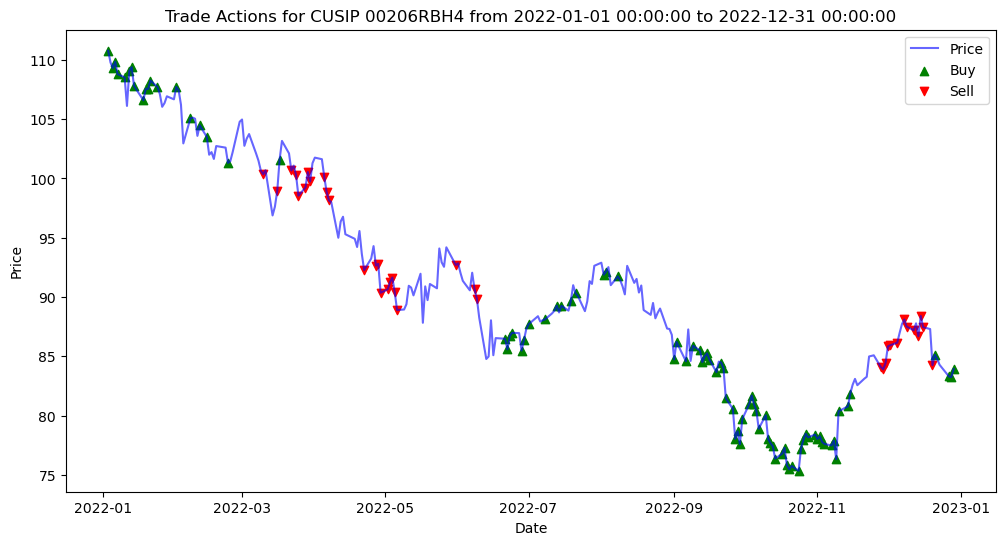

In [55]:
#Cusip Trade Signals
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

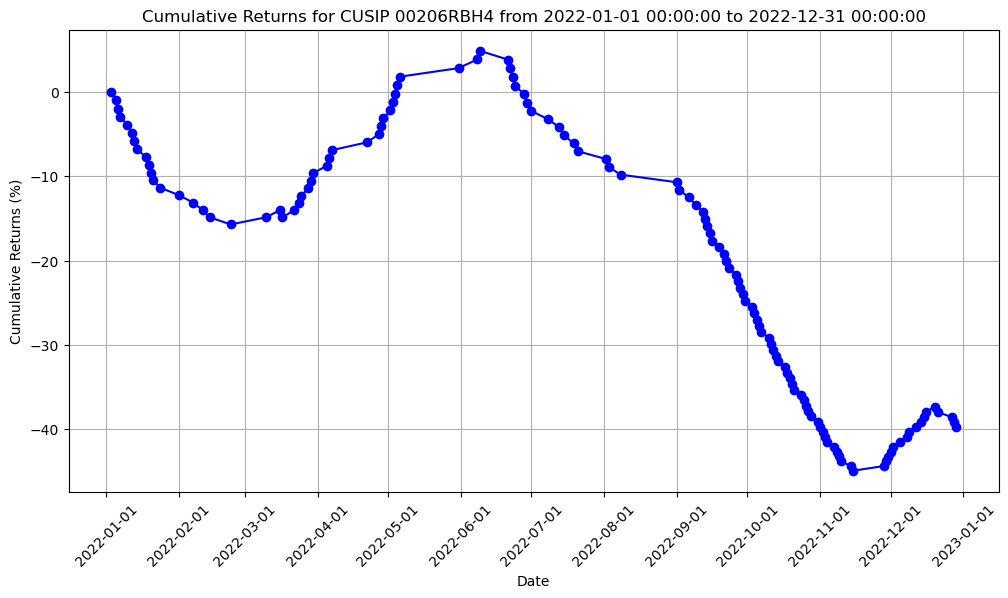

In [56]:
#Cusip Cumulative Returns
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBH4', trade_actions, '2022-01-01', '2022-12-31')

## CUSIP 00206RBK7 from Jan - June 2023

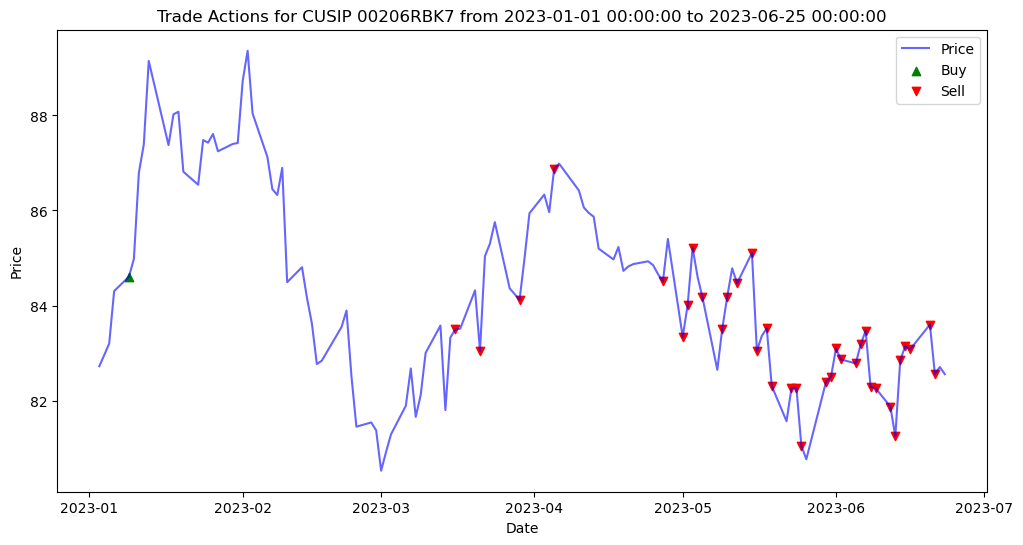

In [57]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBK7', start_date='2023-01-01', end_date='2023-06-25')

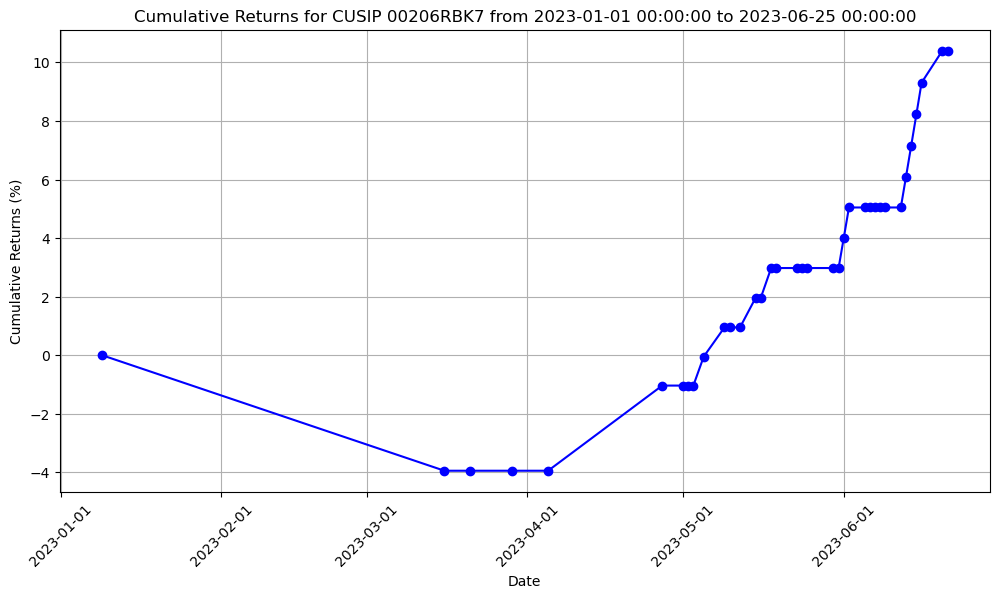

In [58]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBK7', trade_actions, '2023-01-01', '2023-06-25')

In [59]:
print_performance_summary(trade_dates, portfolio_values, wins, losses, max_drawdown)

Performance Summary:
Metric                        Value          
---------------------------------------------
Total Trades                  297549         
Winning Trades                181337         
Losing Trades                 116212         
Win Percentage                60.94          %


C:\Users\zulla\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


# 5. Results and Examples for 3% Threshold

In [61]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.03)

## CUSIP 00206RBH4 for 2022

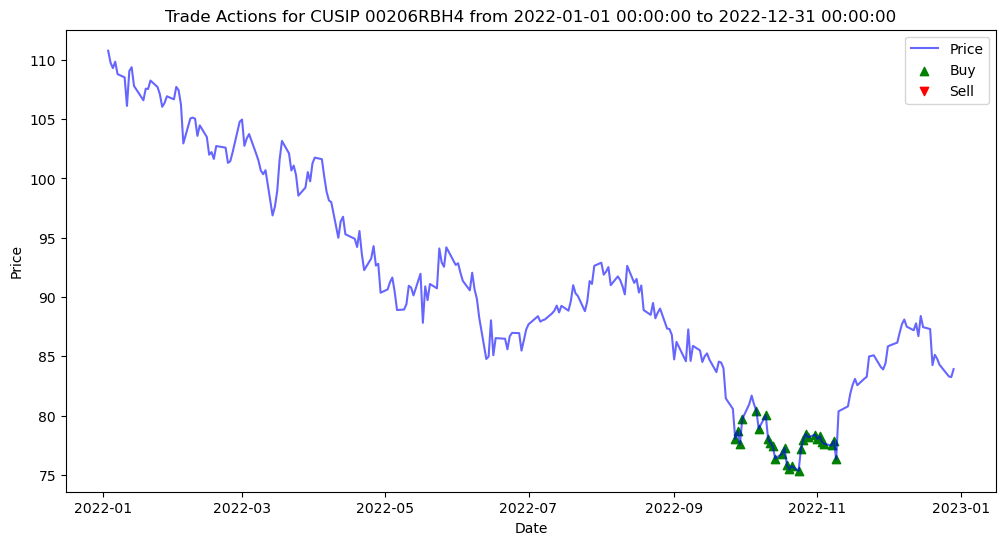

In [62]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

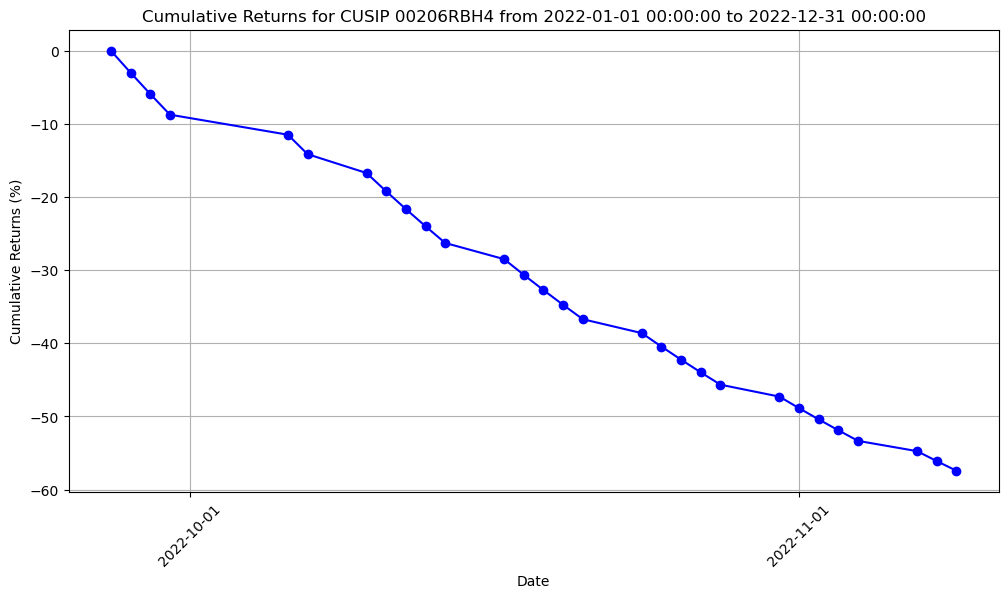

In [63]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBH4', trade_actions, '2022-01-01', '2022-12-31')

## CUSIP 00206RBK7 from Jan - June 2023

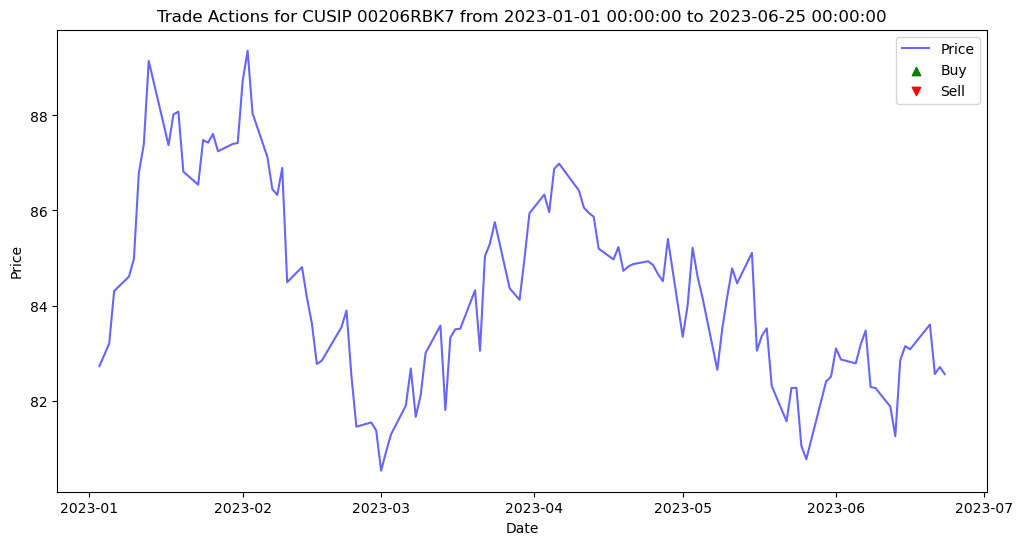

In [64]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBK7', start_date='2023-01-01', end_date='2023-06-25')

In [29]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBK7', trade_actions, '2023-01-01', '2023-06-25')

No trade data available for CUSIP 00206RBK7 in the specified time frame.


# Results and Examples for 5% Threshold

In [30]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown = backtest_strategy(predicted_prices_df, trade_threshold=0.05)

# CUSIP 00206RBH4 for 2022

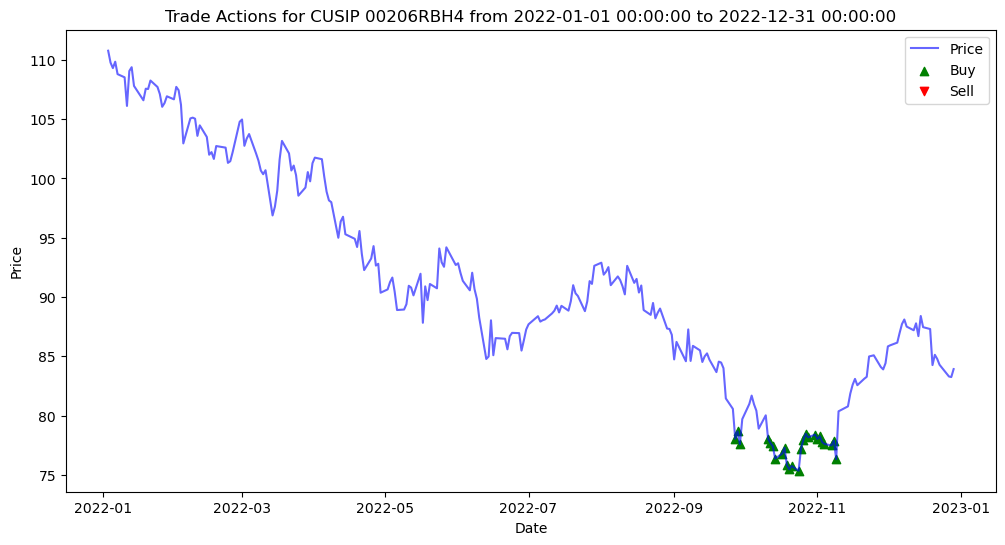

In [31]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

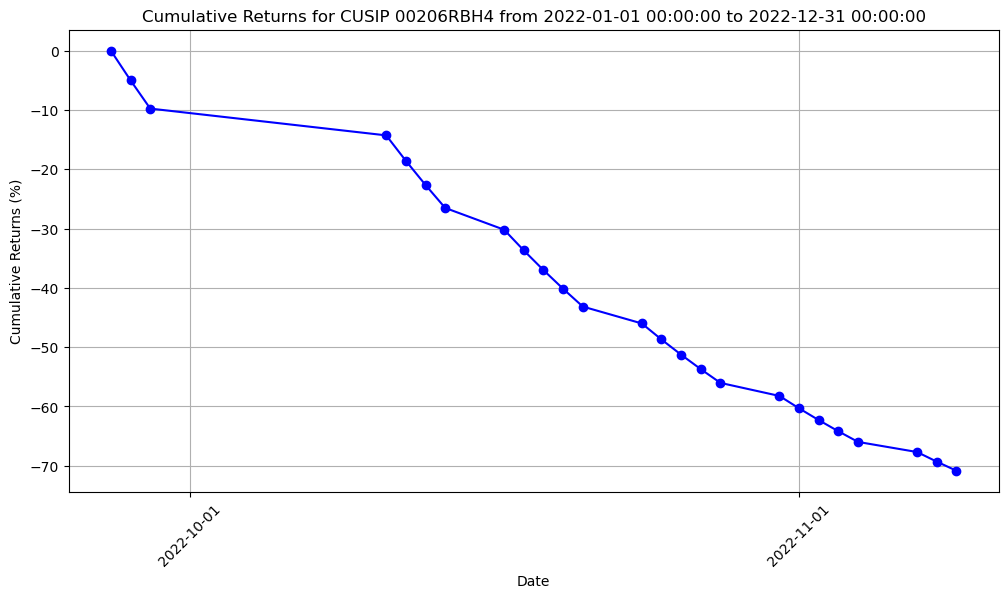

In [32]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBH4', trade_actions, '2022-01-01', '2022-12-31')

# CUSIP 00206RBK7 from Jan - June 2023

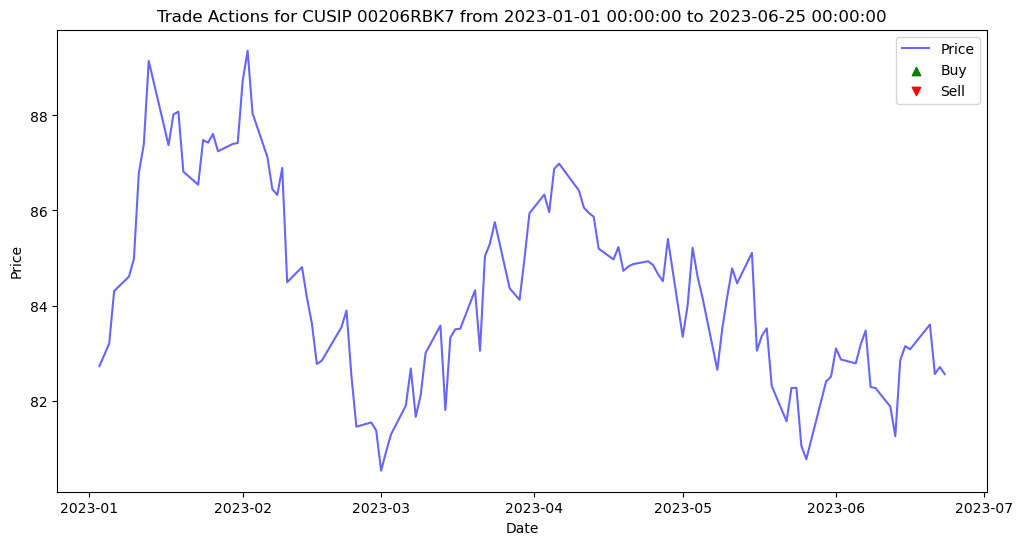

In [33]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBK7', start_date='2023-01-01', end_date='2023-06-25')

# 6. Results and Examples for 0.5% Threshold

In [65]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.005)

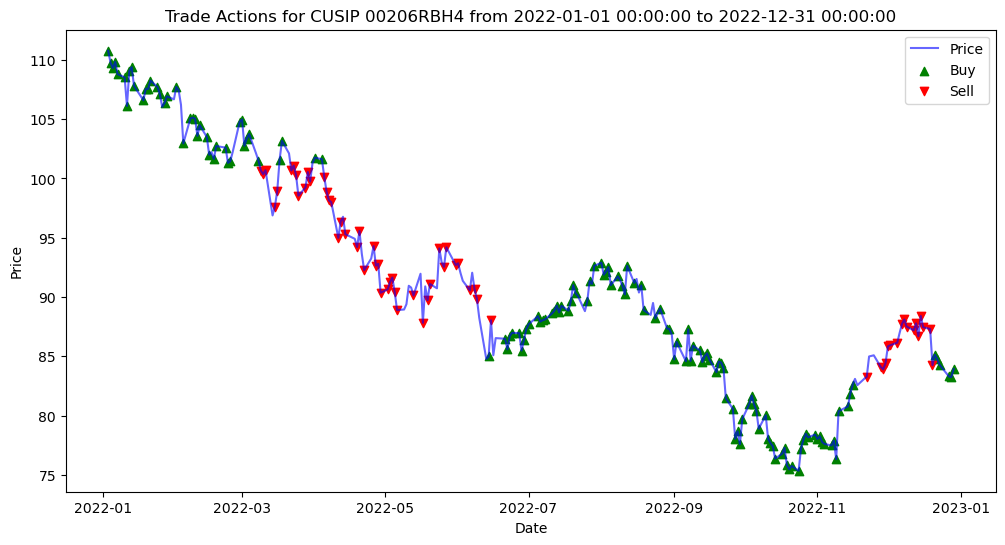

In [66]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

# 2 % and search of a good visualization

In [72]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.02)

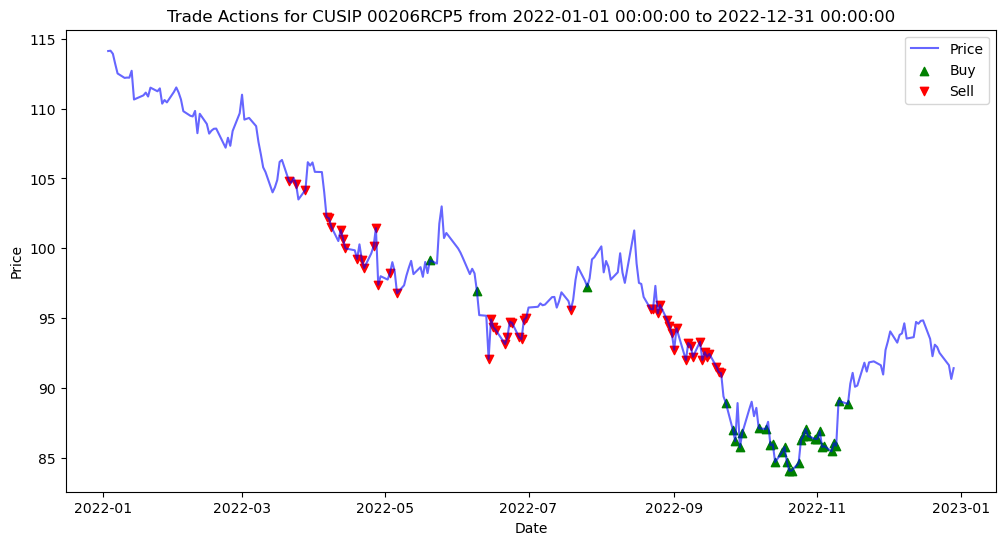

In [75]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RCP5', start_date='2022-01-01', end_date='2022-12-31')

# 7. Most Profitable CUSIPs and Trades

In [67]:
print("Most Profitable CUSIPs:")
for cusip, profit in most_profitable_cusips[:10]:  # Adjust the number to view as needed
    print(f"CUSIP: {cusip}, Profit: {profit}")

Most Profitable CUSIPs:
CUSIP: 98978VAL7, Profit: 5.130553811963809e+148
CUSIP: 98978VAH6, Profit: 4.5488722070921646e+147
CUSIP: 96950FAF1, Profit: 4.388994898186785e+147
CUSIP: 96949LAE5, Profit: 1.457882242950577e+147
CUSIP: 96949LAD7, Profit: 1.11050354678716e+147
CUSIP: 961214DW0, Profit: 2.7512002626389604e+146
CUSIP: 96949LAC9, Profit: 2.5635586395659086e+146
CUSIP: 95040QAD6, Profit: 6.17547584661785e+145
CUSIP: 94974BGU8, Profit: 4.086580046131412e+145
CUSIP: 94974BGT1, Profit: 3.9805925151512934e+145


In [68]:
# Print the best trades
print("Best Trades:")
for trade in best_trades[:10]:  # Adjust the number to view as needed
    print(f"Date: {trade['Date']}, CUSIP: {trade['CUSIP']}, Profit: {trade['Profit']}")

Best Trades:
Date: 2023-03-14 00:00:00, CUSIP: 98978VAL7, Profit: 3.4055607780609972e+146
Date: 2023-03-13 00:00:00, CUSIP: 98978VAL7, Profit: 3.388617689612957e+146
Date: 2023-03-10 00:00:00, CUSIP: 98978VAL7, Profit: 3.3717588951373344e+146
Date: 2023-03-09 00:00:00, CUSIP: 98978VAL7, Profit: 3.354983975261019e+146
Date: 2023-03-08 00:00:00, CUSIP: 98978VAL7, Profit: 3.3382925126974952e+146
Date: 2023-03-07 00:00:00, CUSIP: 98978VAL7, Profit: 3.3216840922362803e+146
Date: 2023-03-06 00:00:00, CUSIP: 98978VAL7, Profit: 3.3051583007327037e+146
Date: 2023-03-03 00:00:00, CUSIP: 98978VAL7, Profit: 3.2887147270971176e+146
Date: 2023-03-02 00:00:00, CUSIP: 98978VAL7, Profit: 3.272352962285698e+146
Date: 2023-03-01 00:00:00, CUSIP: 98978VAL7, Profit: 3.2560725992893158e+146


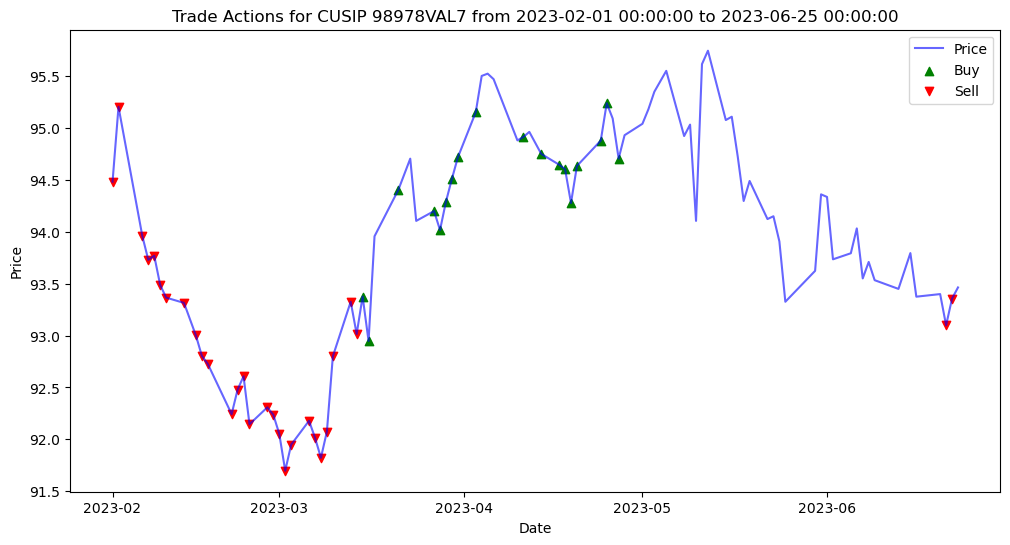

In [71]:
plot_cusip_trades(predicted_prices_df, trade_actions, '98978VAL7', start_date='2023-02-01', end_date='2023-06-25')